# EB Fields
author: Louis Richard\
Plots E and B time series and of burst mode electric field in GSE coordinates and field-aligned coordinates. Plots spectrograms of paralleland perpendicular electric fields and fluctuating magnetic field.

In [1]:
%matplotlib inline
import time

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy import constants

from pyrfu import mms, pyrf
from pyrfu.plot import plot_line, plot_spectr, use_pyrfu_style

use_pyrfu_style(usetex=True)

Load IGRF coefficients ...


## Define time interval, data path and spacecraft index

In [2]:
mms.db_init(default="local", local="/Volumes/mms")

tint = ["2015-10-30T05:15:20.000", "2015-10-30T05:16:20.000"]
ic = 1

[12-Mar-24 11:15:14] INFO: Updating MMS data access configuration in /usr/local/lib/python3.11/site-packages/pyrfu/mms/config.json...
[12-Mar-24 11:15:14] INFO: Updating MMS SDC credentials in /Users/louisr/.config/python_keyring...


## Load data

### Load FGM data

In [3]:
b_xyz = mms.get_data("b_gse_fgm_brst_l2", tint, ic)
b_mag = pyrf.norm(b_xyz)

[12-Mar-24 11:15:14] INFO: Loading mms1_fgm_b_gse_brst_l2...


### Load EDP data

In [4]:
e_xyz = mms.get_data("e_gse_edp_brst_l2", tint, ic)

[12-Mar-24 11:15:14] INFO: Loading mms1_edp_dce_gse_brst_l2...


### Load SCM data

In [5]:
b_scm = mms.get_data("b_gse_scm_brst_l2", tint, ic)

[12-Mar-24 11:15:14] INFO: Loading mms1_scm_acb_gse_scb_brst_l2...


### Load FPI data

In [6]:
n_e = mms.get_data("ne_fpi_brst_l2", tint, ic)
n_i = mms.get_data("ni_fpi_brst_l2", tint, ic)

t_gse_i = mms.get_data("ti_gse_fpi_brst_l2", tint, ic)
t_gse_e = mms.get_data("te_gse_fpi_brst_l2", tint, ic)

[12-Mar-24 11:15:15] INFO: Loading mms1_des_numberdensity_brst...
[12-Mar-24 11:15:15] INFO: Loading mms1_dis_numberdensity_brst...
[12-Mar-24 11:15:15] INFO: Loading mms1_dis_temptensor_gse_brst...
[12-Mar-24 11:15:15] INFO: Loading mms1_des_temptensor_gse_brst...


## Compute low and high frequency electric field and magnetic field fluctuations in FAC

### Rotate E and B into field-aligned coordinates

In [7]:
e_fac = pyrf.convert_fac(e_xyz, b_xyz, [1, 0, 0])
b_fac = pyrf.convert_fac(b_scm, b_xyz, [1, 0, 0])

#### Bandpass filter E and B waveforms

In [8]:
fmin, fmax = [0.5, 1000]  # Hz
e_fac_hf = pyrf.filt(e_fac, fmin, 0, 3)
e_fac_lf = pyrf.filt(e_fac, 0, fmin, 3)
b_fac_hf = pyrf.filt(b_fac, fmin, 0, 3)

## Wavelet transform of the electric field and the magnetic field fluctuations

### Compute wavelet transforms

In [9]:
nf = 100
e_cwt = pyrf.wavelet(e_fac, f=[fmin, fmax], nf=nf)
b_cwt = pyrf.wavelet(b_fac, f=[fmin, fmax], nf=nf)

### Compress wavelet transform

In [10]:
e_cwt_t, e_cwt_perp1, e_cwt_perp2, e_cwt_para = pyrf.compress_cwt(e_cwt, 100)
b_cwt_t, b_cwt_perp1, b_cwt_perp2, b_cwt_para = pyrf.compress_cwt(b_cwt, 100)

options = dict(coords=[e_cwt_t, e_cwt.frequency], dims=["time", "frequency"])
e_perp_cwt = xr.DataArray(e_cwt_perp1 + e_cwt_perp2, **options)
e_para_cwt = xr.DataArray(e_cwt_para, **options)

options = dict(coords=[b_cwt_t, b_cwt.frequency], dims=["time", "frequency"])
b_tota_cwt = xr.DataArray(b_cwt_perp1 + b_cwt_perp2 + b_cwt_para, **options)

## Compute characteristic frequencies

In [11]:
t_fac_i = mms.rotate_tensor(t_gse_i, "fac", b_xyz, "pp")
t_i = pyrf.trace(t_fac_i) / 3

t_fac_e = mms.rotate_tensor(t_gse_e, "fac", b_xyz, "pp")
t_e = pyrf.trace(t_fac_e) / 3

pparams = pyrf.plasma_calc(b_xyz, t_i, t_e, n_i, n_e)

[12-Mar-24 11:16:00] INFO: Using averages in resample
[12-Mar-24 11:16:00] INFO: Using averages in resample


## Plot figure

In [12]:
legend_options = dict(ncol=4, handlelength=1.5, loc="upper right", frameon=False)
spectr_options = dict(yscale="log", cscale="log", cmap="Spectral_r")

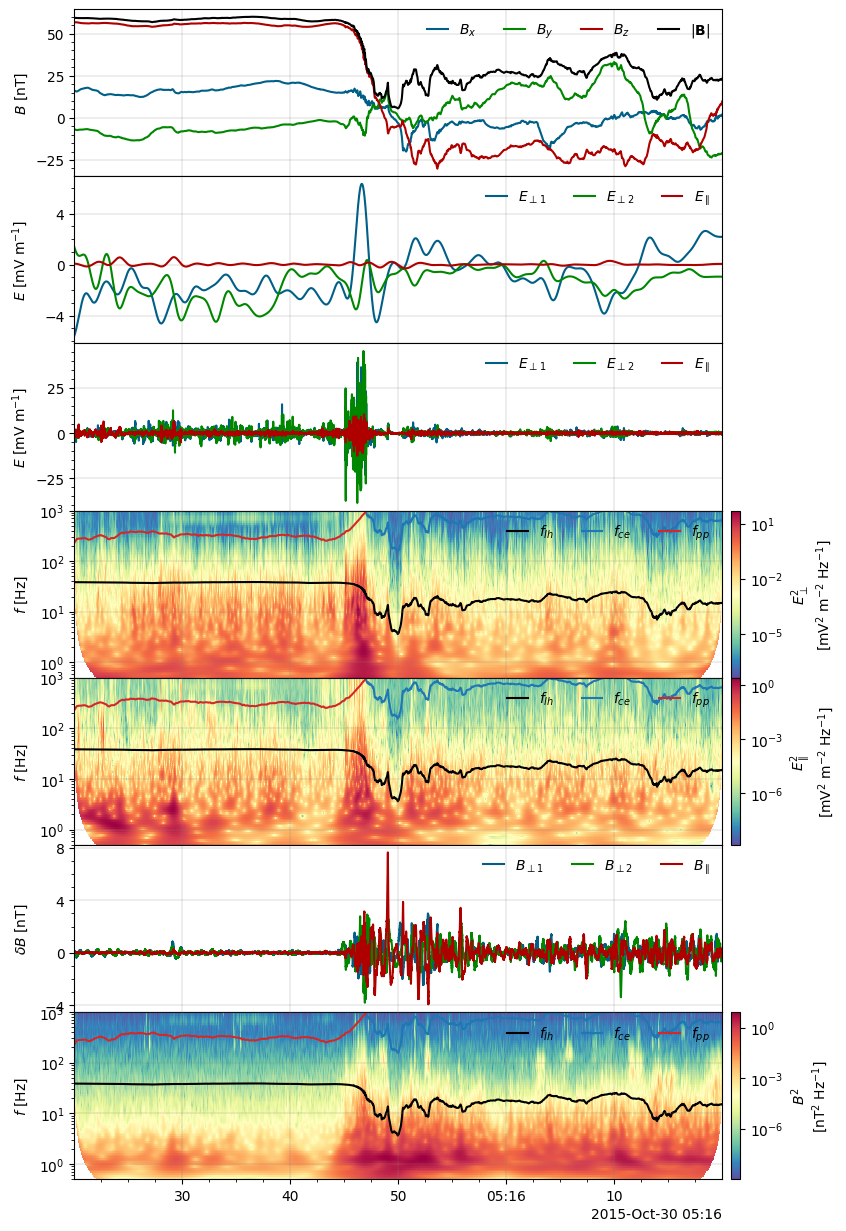

In [13]:
f, axs = plt.subplots(7, sharex="all", figsize=(9, 13))
f.subplots_adjust(hspace=0, left=0.1, right=0.82, bottom=0.05, top=0.95)

plot_line(axs[0], b_xyz)
plot_line(axs[0], b_mag, color="k")
axs[0].set_ylabel(r"$B~[\mathrm{nT}]$")
labels = ["$B_x$", "$B_y$", "$B_z$", r"$|\mathbf{B}|$"]
axs[0].legend(labels, **legend_options)

plot_line(axs[1], e_fac_lf)
axs[1].set_ylabel(r"$E~[\mathrm{mV}~\mathrm{m}^{-1}]$")
axs[1].legend([r"$E_{\bot 1}$", r"$E_{\bot 2}$", r"$E_{\parallel}$"], **legend_options)

plot_line(axs[2], e_fac_hf)
axs[2].set_ylabel("$E$ [mV m$^{-1}$]")
axs[2].legend([r"$E_{\bot 1}$", r"$E_{\bot 2}$", r"$E_{\parallel}$"], **legend_options)

axs[3], caxs3 = plot_spectr(axs[3], e_perp_cwt, **spectr_options)
axs[3].set_ylabel(r"$f~[\mathrm{Hz}]$")
caxs3.set_ylabel(
    r"$E_{\bot}^2$" + "\n" + r"$[\mathrm{mV}^2~\mathrm{m}^{-2}~\mathrm{Hz}^{-1}$]"
)
plot_line(axs[3], pparams.f_lh, color="k", label="$f_{lh}$")
plot_line(axs[3], pparams.f_ce, color="tab:blue", label="$f_{ce}$")
plot_line(axs[3], pparams.f_pp, color="tab:red", label="$f_{pp}$")
axs[3].legend(**legend_options)
axs[3].set_yticks([1e0, 1e1, 1e2, 1e3])

axs[4], caxs4 = plot_spectr(axs[4], e_para_cwt, **spectr_options)
axs[4].set_ylabel(r"$f~[\mathrm{Hz}]$")
caxs4.set_ylabel(
    r"$E_{\parallel}^2$" + "\n" + r"$[\mathrm{mV}^2~\mathrm{m}^{-2}~\mathrm{Hz}^{-1}$]"
)
plot_line(axs[4], pparams.f_lh, color="k", label="$f_{lh}$")
plot_line(axs[4], pparams.f_ce, color="tab:blue", label="$f_{ce}$")
plot_line(axs[4], pparams.f_pp, color="tab:red", label="$f_{pp}$")
axs[4].legend(**legend_options)
axs[4].set_yticks([1e0, 1e1, 1e2, 1e3])

plot_line(axs[5], b_fac_hf)
axs[5].set_ylabel(r"$\delta B~[\mathrm{nT}]$")
axs[5].legend([r"$B_{\bot 1}$", r"$B_{\bot 2}$", r"$B_{\parallel}$"], **legend_options)

axs[6], caxs6 = plot_spectr(axs[6], b_tota_cwt, **spectr_options)
axs[6].set_ylabel(r"$f~[\mathrm{Hz}]$")
caxs6.set_ylabel("$B^2$" + "\n" + r"$[\mathrm{nT}^2~\mathrm{Hz}^{-1}$]")
plot_line(axs[6], pparams.f_lh, color="k", label="$f_{lh}$")
plot_line(axs[6], pparams.f_ce, color="tab:blue", label="$f_{ce}$")
plot_line(axs[6], pparams.f_pp, color="tab:red", label="$f_{pp}$")
axs[6].legend(**legend_options)
axs[6].set_yticks([1e0, 1e1, 1e2, 1e3])

f.align_ylabels(axs)